# "Truth"seeker Project Recreation

In [1]:
# Load the autoreload extension
%load_ext autoreload

# Set autoreload to automatically reload all modules
%autoreload 2

In [2]:
import sys
import os
import torch
from pathlib import Path

# Add the src directory to sys.path
sys.path.append(str(Path().resolve() / "src"))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Import util
import util

Using device: cuda


/home/nbuser/justinjohnson2/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import pandas as pd
from torch import cuda
from sklearn.model_selection import train_test_split
from datasets import Dataset

device = 'cuda' if cuda.is_available() else 'cpu'

device

'cuda'

In [4]:
DATA_PATH = "truthseeker.csv"
df = pd.read_csv(DATA_PATH)
# Comment on on actual execution. For development, this small sample should run quickly on the CPU
#df = df.sample(frac=0.01,  random_state=27)
df.drop(columns=["Unnamed: 0"], inplace=True)
df = df[~df["5_label_majority_answer"].isin(["NO MAJORITY", "Unrelated"])]

clean_cols = ["statement", "tweet"]
df[clean_cols] = df[clean_cols].applymap(util.clean_text)

print(df.shape)
df.head()

/tmp/ipykernel_321986/2385177840.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[clean_cols] = df[clean_cols].applymap(util.clean_text)


(111593, 8)


,author,statement,target,BinaryNumTarget,manual_keywords,tweet,5_label_majority_answer,3_label_majority_answer
0,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",Biden Blunders 6 Month Update Inflation Delta...,Mostly Agree,Agree
2,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",THE SUPREME COURT is siding with super rich pr...,Agree,Agree
3,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",Biden Blunders Broken campaign promises Infla...,Mostly Agree,Agree
4,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",I agree. The confluence of events right now i...,Agree,Agree
5,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",I've said this before but it really is incredi...,Agree,Agree


In [5]:
# Combine tweet + statement + "ground truth" value for training.
df['full'] = df['target'].astype(str) + ' Statement: ' + df['statement'] + '| Tweet: ' + df['tweet']
df['full']

0         True Statement: End of eviction moratorium mea...
2         True Statement: End of eviction moratorium mea...
3         True Statement: End of eviction moratorium mea...
4         True Statement: End of eviction moratorium mea...
5         True Statement: End of eviction moratorium mea...
                                ...                        
134192    False Statement: Joe Bidens great grandfather ...
134193    False Statement: Joe Bidens great grandfather ...
134194    False Statement: Joe Bidens great grandfather ...
134195    False Statement: Joe Bidens great grandfather ...
134197    False Statement: Joe Bidens great grandfather ...
Name: full, Length: 111593, dtype: object

In [6]:
#CATEGORY = "5_label_majority_answer"
CATEGORY = "3_label_majority_answer"
df["labels"] = df[CATEGORY].astype("category").cat.codes
df.head(3)

,author,statement,target,BinaryNumTarget,manual_keywords,tweet,5_label_majority_answer,3_label_majority_answer,full,labels
0,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",Biden Blunders 6 Month Update Inflation Delta...,Mostly Agree,Agree,True Statement: End of eviction moratorium mea...,0
2,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",THE SUPREME COURT is siding with super rich pr...,Agree,Agree,True Statement: End of eviction moratorium mea...,0
3,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",Biden Blunders Broken campaign promises Infla...,Mostly Agree,Agree,True Statement: End of eviction moratorium mea...,0


In [7]:
# Split data into train (80%), validation (10%), and test (10%) splits
train_statements, temp_statements = train_test_split(df['statement'].unique(), test_size=0.2, random_state=27)
valid_statements, test_statements = train_test_split(temp_statements, test_size=0.5, random_state=27)

# Create the dataframes based on the statements
train_df = df[df['statement'].isin(train_statements)]
valid_df = df[df['statement'].isin(valid_statements)]
test_df = df[df['statement'].isin(test_statements)]

train_df.head(3)

,author,statement,target,BinaryNumTarget,manual_keywords,tweet,5_label_majority_answer,3_label_majority_answer,full,labels
0,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",Biden Blunders 6 Month Update Inflation Delta...,Mostly Agree,Agree,True Statement: End of eviction moratorium mea...,0
2,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",THE SUPREME COURT is siding with super rich pr...,Agree,Agree,True Statement: End of eviction moratorium mea...,0
3,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",Biden Blunders Broken campaign promises Infla...,Mostly Agree,Agree,True Statement: End of eviction moratorium mea...,0


In [8]:
# Convert train and test DataFrames into Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
valid_dataset = Dataset.from_pandas(valid_df)

train_dataset = train_dataset.map(util.tokenize_function, batched=True)
test_dataset = test_dataset.map(util.tokenize_function, batched=True)
valid_dataset = valid_dataset.map(util.tokenize_function, batched=True)

Map: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11438/11438 [00:06<00:00, 1673.52 examples/s]


In [9]:
OUT = "2_class"
# OUT = "4_class"
test_acc, valid_acc = util.train(train_dataset, test_dataset, valid_dataset, OUT)

/home/nbuser/justinjohnson2/venv/lib/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/nbuser/justinjohnson2/src/util.py:163: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.497600,0.494375,0.969917
2,0.431900,0.419700,0.969917
3,0.407200,0.399449,0.969917


Test Accuracy: 0.9699168117624298
Validation Accuracy: 0.9705368071341144


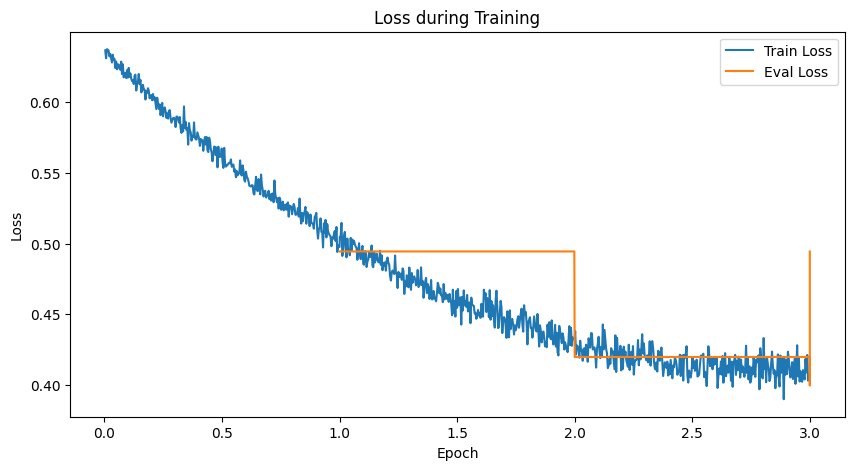

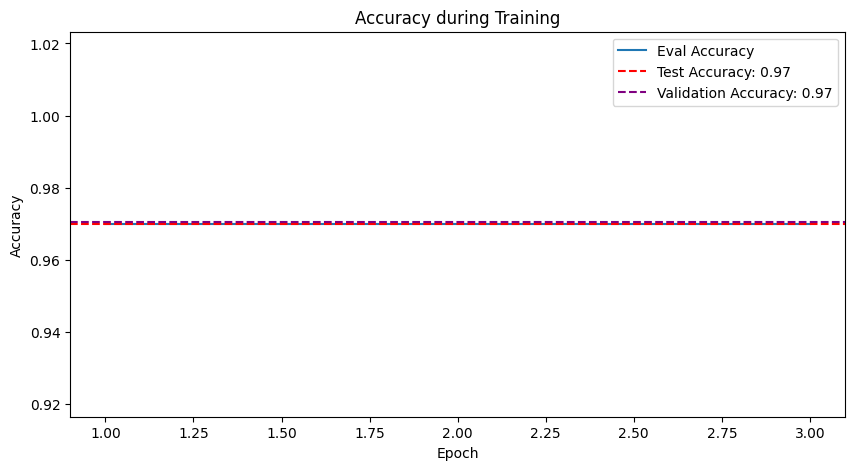

In [12]:
import matplotlib.pyplot as plt

# Load the training metrics CSV file
df = pd.read_csv('logs/2_class/training_metrics.csv')
# Forward-fill NaN values with the previous non-NaN value
df['eval_loss'] = df['eval_loss'].ffill()
df['train_loss'] = df['train_loss'].ffill()
df['eval_accuracy'] = df['eval_accuracy'].ffill()
df['train_accuracy'] = df['train_accuracy'].ffill()

# Plot training and evaluation loss
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['train_loss'], label='Train Loss')
plt.plot(df['epoch'], df['eval_loss'], label='Eval Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss during Training')
plt.savefig(f"./logs/{OUT}/loss.png")
plt.show()

# Plot evaluation accuracy
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['eval_accuracy'], label='Eval Accuracy')
plt.axhline(y=test_acc, color='red', linestyle='--', label=f'Test Accuracy: {test_acc:.2f}')
plt.axhline(y=valid_acc, color='purple', linestyle='--', label=f'Validation Accuracy: {valid_acc:.2f}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy during Training')
plt.savefig(f"./logs/{OUT}/accuracy.png")
plt.show()